# Behind the pipeline (PyTorch)

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

[{'label': 'POSITIVE', 'score': 0.9598047137260437},
 {'label': 'NEGATIVE', 'score': 0.9994558095932007}]

#### Pipeline consists of three steps:

- Tokenizer
- Model
- Postprocessing

Let's break these steps down:

#### Tokenizer:

A tokenizer is responsible for:

- Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens
- Mapping each token to an integer
- Adding additional inputs that may be useful to the model

All these steps need to followed in the same way the model was trained and thus we need to use the `from_pretrained` method of `AutoTokenizer` function in the transformers library. 

Each model's info can be gathered from the [model hub](https://huggingface.co/models). 

In [1]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [2]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


The tokeniser outputs a dictinary mapping of the input sentences we passed to it. We have specified (`return_tensors = 'pt'`) that the output be a pytorch tensor so that we can directly feed it to the model we would be using. 

The output itself is a dictionary containing two keys, input_ids and attention_mask. input_ids contains two rows of integers (one for each sentence) that are the unique identifiers of the tokens in each sentence.

#### Going through the model:

We can download our pretrained model the same way we did with our tokenizer. 🤗 Transformers provides an `AutoModel` class which also has a `from_pretrained()` method:

In [4]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


This architecture contains only the base Transformer module: given some inputs, it outputs what we’ll call **hidden states**, also known as features. 

For each model input, we’ll retrieve a high-dimensional vector representing the **contextual understanding of that input by the Transformer model**.

While these hidden states can be useful on their own, they’re usually inputs to another part of the model, known as the head. 

In Chapter 1, the different tasks could have been performed with the same architecture, but each of these tasks will have a different head associated with it.

In [5]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


The vector output by the Transformer module is usually large. It generally has three dimensions:

- **Batch size**: The number of sequences processed at a time (2 in our example).
- **Sequence length**: The length of the numerical representation of the sequence (16 in our example).
- **Hidden size**: The vector dimension of each model input.

It is said to be “high dimensional” because of the last value. The hidden size can be very large (768 is common for smaller models, and in larger models this can reach 3072 or more).

In [7]:
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.1798,  0.2333,  0.6321,  ..., -0.3017,  0.5008,  0.1481],
         [ 0.2758,  0.6497,  0.3200,  ..., -0.0760,  0.5136,  0.1329],
         [ 0.9046,  0.0985,  0.2950,  ...,  0.3352, -0.1407, -0.6464],
         ...,
         [ 0.1466,  0.5661,  0.3235,  ..., -0.3376,  0.5100, -0.0561],
         [ 0.7500,  0.0487,  0.1738,  ...,  0.4684,  0.0030, -0.6084],
         [ 0.0519,  0.3729,  0.5223,  ...,  0.3584,  0.6500, -0.3883]],

        [[-0.2937,  0.7283, -0.1497,  ..., -0.1187, -1.0227, -0.0422],
         [-0.2206,  0.9384, -0.0951,  ..., -0.3643, -0.6605,  0.2407],
         [-0.1536,  0.8987, -0.0728,  ..., -0.2189, -0.8528,  0.0710],
         ...,
         [-0.3017,  0.9002, -0.0200,  ..., -0.1082, -0.8412, -0.0861],
         [-0.3338,  0.9674, -0.0729,  ..., -0.1952, -0.8181, -0.0634],
         [-0.3454,  0.8824, -0.0426,  ..., -0.0993, -0.8329, -0.1065]]],
       grad_fn=<NativeLayerNormBackward>), hidden_states=None, attentions=None)

#### Model Heads: Making sense of numbers:

The model heads take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers:

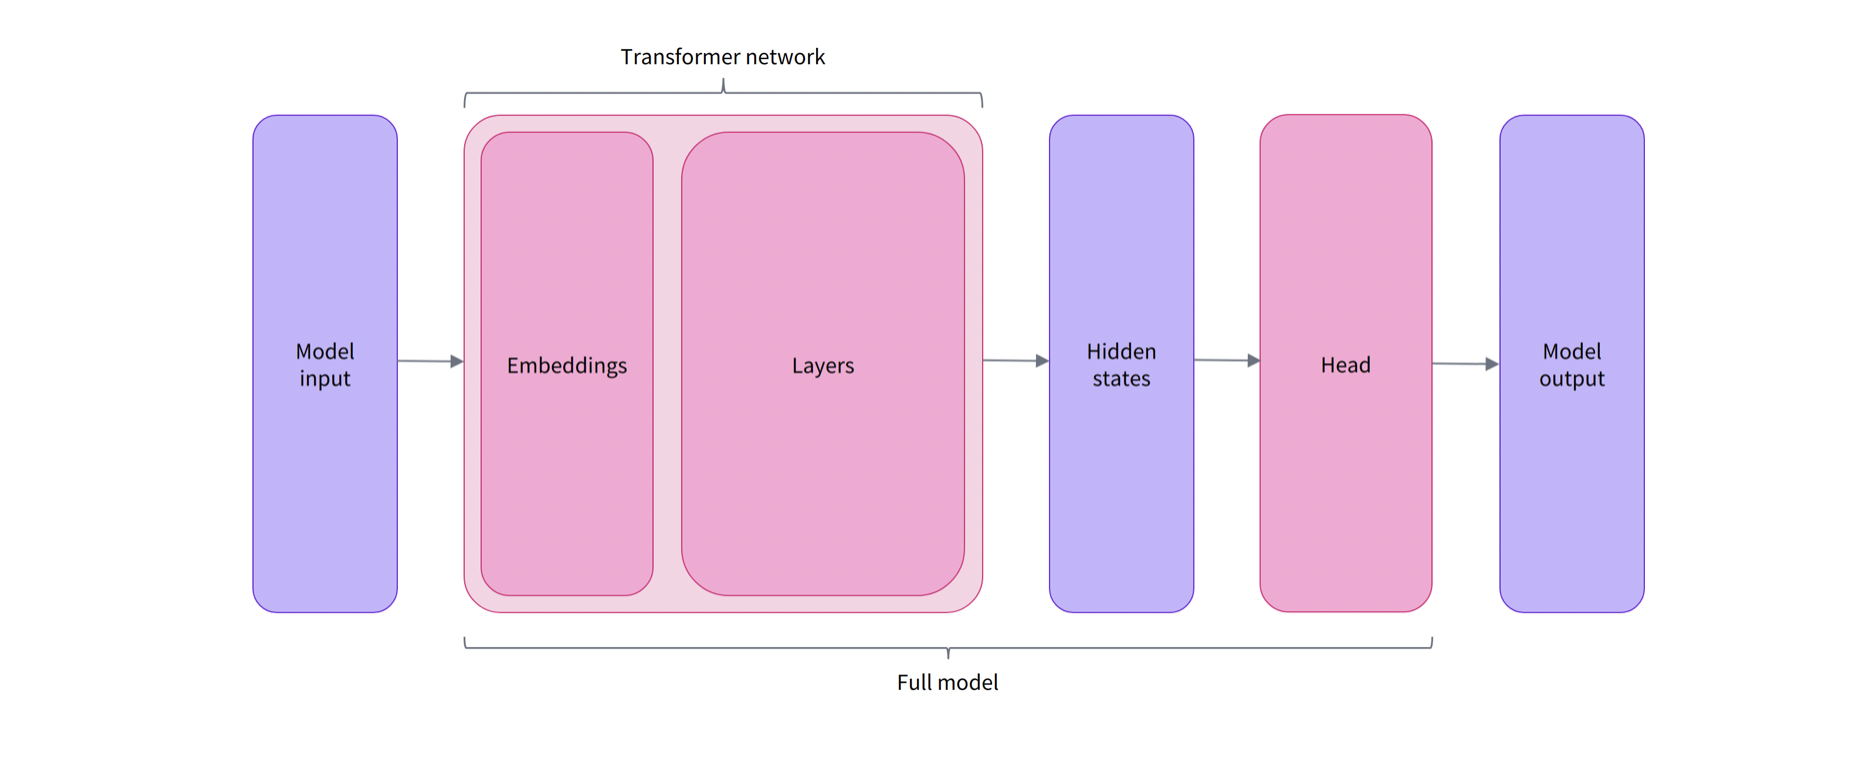

The output of the Transformer model is sent directly to the model head to be processed.

> In this diagram, the model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.

There are many different architectures available in 🤗 Transformers, with each one designed around tackling a specific task. Here is a non-exhaustive list:

- *Model (retrieve the hidden states)
- *ForCausalLM
- *ForMaskedLM
- *ForMultipleChoice
- *ForQuestionAnswering
- *ForSequenceClassification
- *ForTokenClassification
- and others 🤗

For our example, we will need a model with a sequence classification head (to be able to classify the sentences as positive or negative). So, we won’t actually use the **AutoModel** class, but **AutoModelForSequenceClassification**:

In [8]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

Now if we look at the shape of our inputs, the dimensionality will be much lower: the model head takes as input the high-dimensional vectors we saw before, and outputs vectors containing two values (one per label):

In [9]:
print(outputs.logits.shape)

torch.Size([2, 2])


Since we have just two sentences and two labels, the result we get from our model is of shape 2 x 2.

#### Postprocessing the output:

In [10]:
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward>)


> Our model predicted **[-1.5607, 1.6123]** for the first sentence and **[ 4.1692, -3.3464]** for the second one. Those are not probabilities but **logits**, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a **SoftMax** layer (all 🤗 Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy):

In [14]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward>)


Now we can see that the model predicted **[0.0402, 0.9598]** for the first sentence and **[0.9995, 0.0005]** for the second one. These are recognizable probability scores.

To get the labels corresponding to each position, we can inspect the **id2label** attribute of the model config (more on this in the next section):

In [15]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

Now we can conclude that the model predicted the following:

- First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598
- Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005


We have successfully reproduced the three steps of the pipeline: preprocessing with tokenizers, passing the inputs through the model, and postprocessing! Now let’s take some time to dive deeper into each of those steps.